<a href="https://colab.research.google.com/github/sidhu2690/YOLO_V8_PyTorch/blob/main/YOLO_V8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ultralytics torchvision opencv-python pycocotools torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [2]:
!pip install ultralytics pycocotools torchinfo -q

# Download COCO dataset
!wget -q http://images.cocodataset.org/zips/train2017.zip
!wget -q http://images.cocodataset.org/zips/val2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q train2017.zip
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

print("Dataset downloaded!")

Dataset downloaded!


In [3]:
import random
import numpy as np
import cv2
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from ultralytics import YOLO
from ultralytics.utils.loss import v8DetectionLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics.utils.nms import non_max_suppression
from pycocotools.cocoeval import COCOeval
import json

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# ============================================
# CONFIG
# ============================================
IMG_SIZE = 640
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-3
DATA_PERCENT = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

COCO_CAT_ID_TO_INDEX = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9,
    11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19,
    22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29,
    35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39,
    46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49,
    56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59,
    67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69,
    80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79
}

print(f"Device: {DEVICE}")

Device: cuda


In [5]:
# ============================================
# LOAD MODEL
# ============================================
class Hyperparameters:
    box = 7.5
    cls = 0.5
    dfl = 1.5

model = YOLO('yolov8n.pt').model
for param in model.parameters():
    param.requires_grad = True
model = model.to(DEVICE)
model.args = Hyperparameters()

print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable params: 3,157,200


In [6]:
# ============================================
# DATASET
# ============================================
class COCODataset(Dataset):
    def __init__(self, img_dir, ann_file, img_size=640, percent=1.0):
        self.img_dir = img_dir
        self.img_size = img_size
        self.coco = COCO(ann_file)
        all_ids = list(self.coco.imgs.keys())
        self.img_ids = random.sample(all_ids, int(len(all_ids) * percent))
        print(f"Using {len(self.img_ids)} images ({percent*100:.0f}%)")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        img = cv2.imread(f"{self.img_dir}/{img_info['file_name']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        img = cv2.resize(img, (self.img_size, self.img_size))
        img = torch.from_numpy(img.astype(np.float32) / 255.0).permute(2, 0, 1)

        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id, iscrowd=False))

        labels = []
        for ann in anns:
            if ann['category_id'] not in COCO_CAT_ID_TO_INDEX:
                continue
            cls_id = COCO_CAT_ID_TO_INDEX[ann['category_id']]
            x, y, w, h = ann['bbox']
            xc, yc = (x + w/2) / orig_w, (y + h/2) / orig_h
            w, h = w / orig_w, h / orig_h
            if w > 0 and h > 0:
                labels.append([cls_id, max(0, min(1, xc)), max(0, min(1, yc)), max(0, min(1, w)), max(0, min(1, h))])

        return img, torch.tensor(labels, dtype=torch.float32) if labels else torch.zeros((0, 5))


def collate_fn(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs)
    new_labels = []
    for i, lbl in enumerate(labels):
        if len(lbl) > 0:
            batch_idx = torch.full((len(lbl), 1), i, dtype=torch.float32)
            new_labels.append(torch.cat([batch_idx, lbl], dim=1))
    return imgs, torch.cat(new_labels) if new_labels else torch.zeros((0, 6))

In [7]:
# DATALOADER
train_loader = DataLoader(
    COCODataset('/content/train2017', '/content/annotations/instances_train2017.json', IMG_SIZE, DATA_PERCENT),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn, pin_memory=True
)

loading annotations into memory...
Done (t=19.19s)
creating index...
index created!
Using 35486 images (30%)


In [8]:
loss_fn = v8DetectionLoss(model)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("\nSTARTING TRAINING")
print("=" * 50)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs)

        batch_dict = {
            "batch_idx": labels[:, 0] if labels.shape[0] > 0 else torch.zeros(0, device=DEVICE),
            "cls": labels[:, 1] if labels.shape[0] > 0 else torch.zeros(0, device=DEVICE),
            "bboxes": labels[:, 2:6] if labels.shape[0] > 0 else torch.zeros((0, 4), device=DEVICE),
        }

        loss, loss_items = loss_fn(preds, batch_dict)
        if loss.dim() > 0:
            loss = loss.sum()

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

torch.save(model.state_dict(), 'yolov8n_trained.pt')
print("\nModel saved: yolov8n_trained.pt")


STARTING TRAINING


Epoch 1/10: 100%|██████████| 4436/4436 [12:34<00:00,  5.88it/s, loss=40.1153]


Epoch 1 | Loss: 56.3577 | LR: 0.000976


Epoch 2/10: 100%|██████████| 4436/4436 [12:06<00:00,  6.10it/s, loss=29.1967]


Epoch 2 | Loss: 49.3740 | LR: 0.000905


Epoch 3/10: 100%|██████████| 4436/4436 [12:06<00:00,  6.11it/s, loss=31.5930]


Epoch 3 | Loss: 46.0170 | LR: 0.000794


Epoch 4/10: 100%|██████████| 4436/4436 [12:24<00:00,  5.96it/s, loss=36.4731]


Epoch 4 | Loss: 43.4272 | LR: 0.000655


Epoch 5/10: 100%|██████████| 4436/4436 [12:07<00:00,  6.10it/s, loss=33.7267]


Epoch 5 | Loss: 41.1385 | LR: 0.000500


Epoch 6/10: 100%|██████████| 4436/4436 [12:26<00:00,  5.94it/s, loss=31.2695]


Epoch 6 | Loss: 39.1293 | LR: 0.000345


Epoch 7/10: 100%|██████████| 4436/4436 [12:12<00:00,  6.06it/s, loss=31.1672]


Epoch 7 | Loss: 37.1903 | LR: 0.000206


Epoch 8/10: 100%|██████████| 4436/4436 [12:29<00:00,  5.92it/s, loss=33.1679]


Epoch 8 | Loss: 35.4336 | LR: 0.000095


Epoch 9/10: 100%|██████████| 4436/4436 [12:15<00:00,  6.03it/s, loss=31.9159]


Epoch 9 | Loss: 33.9567 | LR: 0.000024


Epoch 10/10: 100%|██████████| 4436/4436 [12:05<00:00,  6.12it/s, loss=26.6475]

Epoch 10 | Loss: 33.0834 | LR: 0.000000

Model saved: yolov8n_trained.pt


In [9]:
# ============================================
# CONFIG
# ============================================
IMG_SIZE = 640
CONF_THRESH = 0.25
IOU_THRESH = 0.45
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INDEX_TO_COCO_CAT = {v: k for k, v in COCO_CAT_ID_TO_INDEX.items()}

COCO_NAMES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# COCO category ID to name mapping
COCO_CAT_ID_TO_NAME = {}
coco_temp = COCO('/content/annotations/instances_val2017.json')
for cat in coco_temp.loadCats(coco_temp.getCatIds()):
    COCO_CAT_ID_TO_NAME[cat['id']] = cat['name']

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [10]:
# ============================================
# LOAD MODEL
# ============================================
model = YOLO('yolov8n.pt').model.to(DEVICE)
model.load_state_dict(torch.load('yolov8n_trained.pt', map_location=DEVICE))
model.eval()
print("Model loaded!")

Model loaded!


In [11]:
# ============================================
# DRAW GROUND TRUTH ANNOTATIONS
# ============================================
def draw_ground_truth(image_path, coco, img_id):
    """Draw ground truth annotations on image"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        x, y, w, h = [int(v) for v in ann['bbox']]
        cat_id = ann['category_id']
        cat_name = COCO_CAT_ID_TO_NAME.get(cat_id, str(cat_id))

        # Draw box (Blue for ground truth)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(img, cat_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return img

In [12]:
# ============================================
# DRAW PREDICTIONS
# ============================================
def draw_predictions(image_path):
    """Draw model predictions on image"""
    img = cv2.imread(image_path)
    orig_h, orig_w = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_tensor = torch.from_numpy(img_resized.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

    # Inference
    with torch.no_grad():
        preds = model(img_tensor)

    results = non_max_suppression(preds, conf_thres=CONF_THRESH, iou_thres=IOU_THRESH)[0]

    # Draw on original RGB image
    img_out = img_rgb.copy()

    for *xyxy, conf, cls in results:
        x1 = int(xyxy[0] * orig_w / IMG_SIZE)
        y1 = int(xyxy[1] * orig_h / IMG_SIZE)
        x2 = int(xyxy[2] * orig_w / IMG_SIZE)
        y2 = int(xyxy[3] * orig_h / IMG_SIZE)

        label = f"{COCO_NAMES[int(cls)]} {conf:.2f}"

        # Draw box (Green for predictions)
        cv2.rectangle(img_out, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_out, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img_out

In [13]:
# ============================================
# COMPARE GROUND TRUTH VS PREDICTION
# ============================================
def compare_gt_vs_pred(image_path, coco, img_id):
    """Show ground truth and prediction side by side"""

    gt_img = draw_ground_truth(image_path, coco, img_id)
    pred_img = draw_predictions(image_path)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(gt_img)
    axes[0].set_title('Ground Truth (Blue)', fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(pred_img)
    axes[1].set_title('Prediction (Green)', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('comparison_result.jpg', dpi=150, bbox_inches='tight')
    plt.show()

    return gt_img, pred_img

In [14]:
# ============================================
# COCO EVALUATION (mAP)
# ============================================
def evaluate(img_dir, ann_file, num_images=500):
    coco_gt = COCO(ann_file)
    img_ids = list(coco_gt.imgs.keys())[:num_images]

    results = []
    for img_id in tqdm(img_ids, desc="Evaluating"):
        img_info = coco_gt.loadImgs(img_id)[0]
        img = cv2.imread(f"{img_dir}/{img_info['file_name']}")
        if img is None:
            continue

        orig_h, orig_w = img.shape[:2]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
        img_tensor = torch.from_numpy(img_resized.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            preds = model(img_tensor)

        dets = non_max_suppression(preds, conf_thres=CONF_THRESH, iou_thres=IOU_THRESH)[0]

        for *xyxy, conf, cls in dets:
            x1 = float(xyxy[0] * orig_w / IMG_SIZE)
            y1 = float(xyxy[1] * orig_h / IMG_SIZE)
            x2 = float(xyxy[2] * orig_w / IMG_SIZE)
            y2 = float(xyxy[3] * orig_h / IMG_SIZE)
            results.append({
                'image_id': img_id,
                'category_id': INDEX_TO_COCO_CAT[int(cls)],
                'bbox': [x1, y1, x2 - x1, y2 - y1],
                'score': float(conf)
            })

    if not results:
        print("No detections!")
        return None

    with open('predictions.json', 'w') as f:
        json.dump(results, f)

    coco_dt = coco_gt.loadRes('predictions.json')
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.params.imgIds = img_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!

COMPARISON: GROUND TRUTH vs PREDICTION

Image 1: 000000403385.jpg


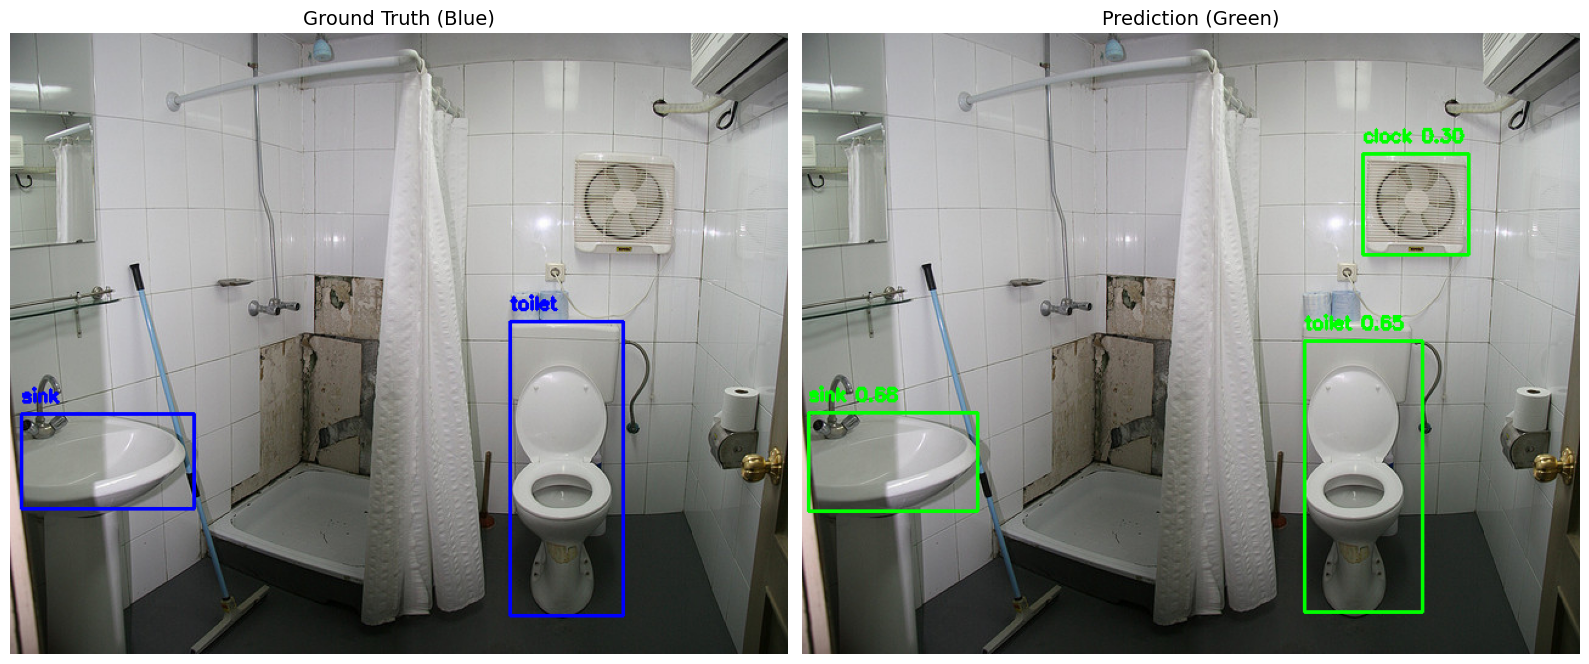


Image 2: 000000006818.jpg


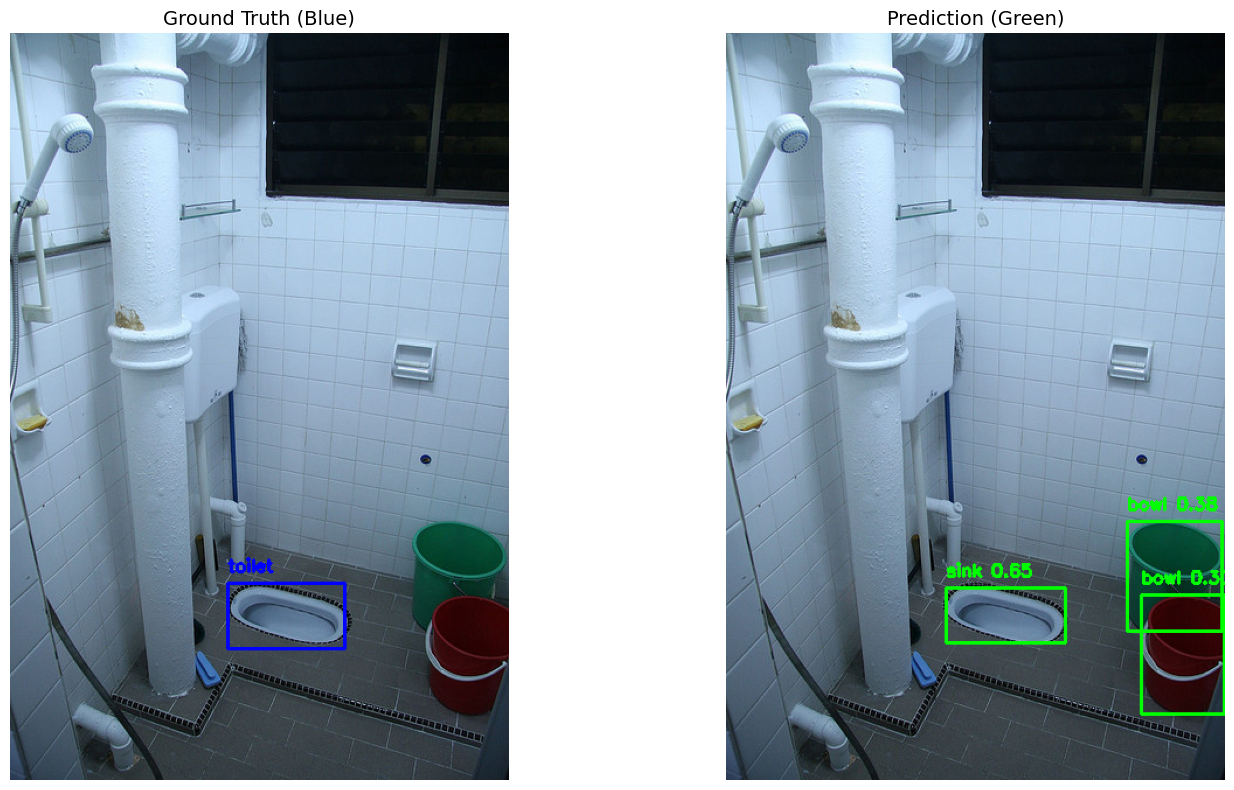


Image 3: 000000480985.jpg


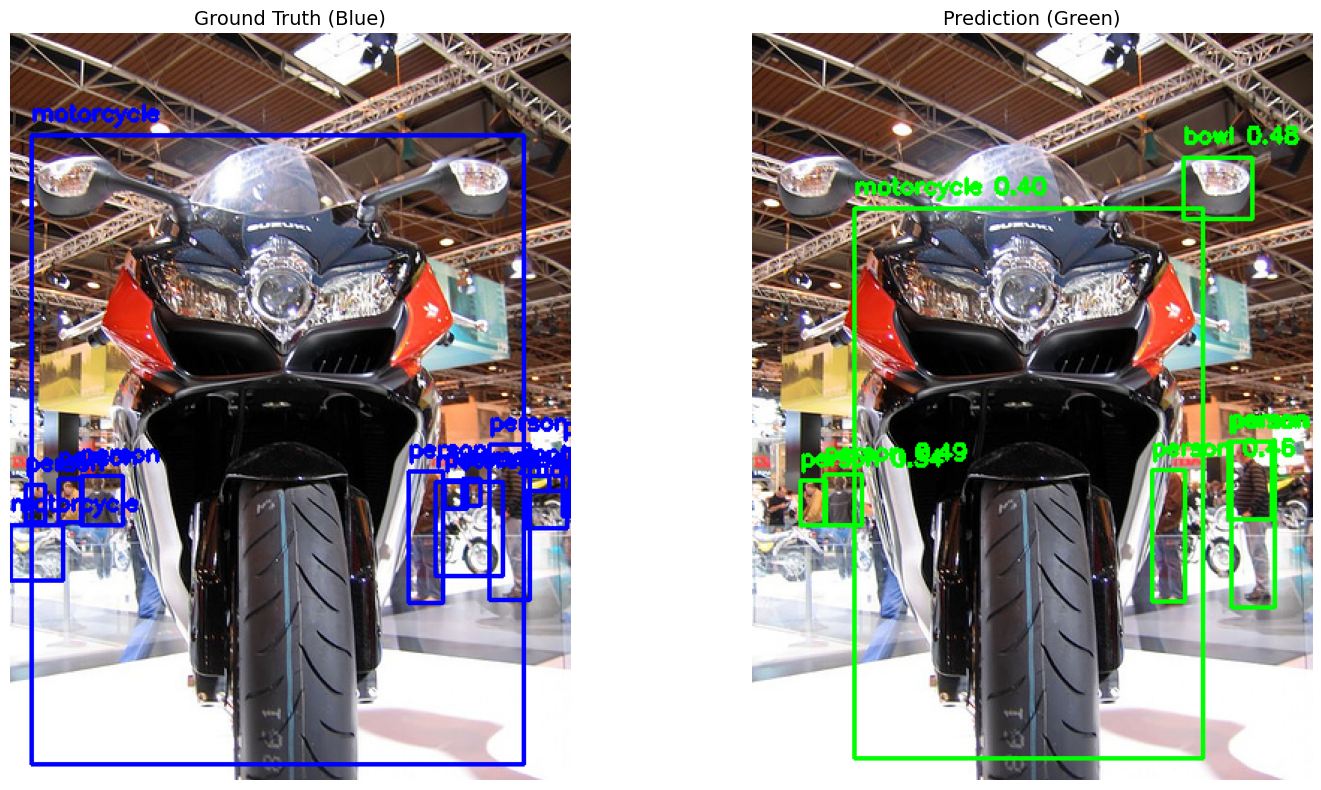


COCO mAP EVALUATION
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


Evaluating: 100%|██████████| 500/500 [00:12<00:00, 41.20it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.75s).
Accumulating evaluation results...
DONE (t=0.55s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [15]:
# ============================================
# RUN TESTS
# ============================================
coco = COCO('/content/annotations/instances_val2017.json')

# Get sample images with annotations
img_ids_with_anns = [img_id for img_id in list(coco.imgs.keys())[:100]
                     if len(coco.getAnnIds(imgIds=img_id)) > 0]

print("\n" + "=" * 50)
print("COMPARISON: GROUND TRUTH vs PREDICTION")
print("=" * 50)

# Show 3 sample images
for i, img_id in enumerate(img_ids_with_anns[5:8]):
    img_info = coco.loadImgs(img_id)[0]
    image_path = f"/content/val2017/{img_info['file_name']}"

    print(f"\nImage {i+1}: {img_info['file_name']}")
    compare_gt_vs_pred(image_path, coco, img_id)

# ============================================
# mAP EVALUATION
# ============================================
print("\n" + "=" * 50)
print("COCO mAP EVALUATION")
print("=" * 50)

stats = evaluate('/content/val2017', '/content/annotations/instances_val2017.json', num_images=500)

if stats is not None:
    print("\n" + "=" * 50)
    print("RESULTS")
    print("=" * 50)
    print(f"mAP@0.5: {stats[1]:.4f}")
    print(f"mAP@0.5:0.95: {stats[0]:.4f}")